## Set Up

In [1]:
import sagemaker, boto3, json
from sagemaker import get_execution_role

aws_role = get_execution_role()
aws_region = boto3.Session().region_name
sess = sagemaker.Session()

## Configure the Image Embedding Endpoint

In [2]:
from sagemaker.predictor import Predictor

endpoint_name = 'jumpstart-example-infer-tensorflow-icem-2022-06-21-17-42-58-843'
model_predictor = Predictor(endpoint_name = endpoint_name,
                           sagemaker_session = sess)

## Query Endpoint & Parse Inference Results

In [3]:
def query(model_predictor, image_file_name):
    """Query the model predictor."""

    with open(image_file_name, "rb") as file:
        input_img_rb = file.read()

    query_response = model_predictor.predict(
        input_img_rb,
        {
            "ContentType": "application/x-image",
            "Accept": "application/json",
        },
    )
    return query_response


def parse_response(query_response):
    """Parse response and return the embedding."""

    model_predictions = json.loads(query_response)
    translation_text = model_predictions["embedding"]
    return translation_text

## Quick Test

In [4]:
from IPython.core.display import HTML

img_name = 'images/00096972-5f6b-44df-917b-f7d21ae5644c.jpg'
query_response = query(model_predictor, img_name)
embedding = parse_response(query_response)

first_5element_embeddings = "{" + ", ".join([str(id) for id in embedding[:5]]) + "}"

display(
    HTML(
        f'<img src={img_name} alt={img_name} align="left" style="width: 250px;"/>'
        f"<figcaption>First-5 elements of the feature vector (embedding) are: {first_5element_embeddings}</figcaption>"
        f"<figcaption>Total length of the feature vector (embedding) is: {len(embedding)}</figcaption>"
    )
)

## Setup OpenSearch Knn search index

In [5]:
import pandas as pd
import time
import requests
import csv

from random import randint
from botocore.exceptions import ClientError

# Setup Clients
os_service = boto3.client('opensearch')

Opensearch is pretty new, especially some of the newer features with latest version.  Please update your libraries to make sure you are using the latest.  You need at least opensearch v1.12 to use `faiss`

In [6]:
!pip install opensearch-py
!pip install requests
!pip install requests-aws4auth

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.6/204.6 KB 6.3 MB/s eta 0:00:00
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Get the domain name for our image-search cluster

In [16]:
domains_response = os_service.list_domain_names()

for domain_name in domains_response['DomainNames']:
    
    if domain_name['DomainName'] == 'jingswu-ab-image-search': 
        describe_response = os_service.describe_domain(
            DomainName=domain_name['DomainName']
        )
        
        opensearch_domain_endpoint = describe_response['DomainStatus']['Endpoint']

print('Elasticsearch domain endpoint: ' + str(opensearch_domain_endpoint))

assert opensearch_domain_endpoint, 'Elasticsearch domain endpoint could not be determined. Ensure Elasticsearch domain has been successfully created and has "retaildemostore" tag before continuing.'

Elasticsearch domain endpoint: search-jingswu-ab-image-search-objkrip5ozc6tafoc7qnnkkhpq.us-west-2.es.amazonaws.com


## Connect and Authenticate to our cluster

In [17]:
from opensearchpy import OpenSearch, RequestsHttpConnection, AWSV4SignerAuth

credentials = boto3.Session().get_credentials()
auth = AWSV4SignerAuth(credentials, aws_region)

opensearch_host = {
    'host' : opensearch_domain_endpoint,
    'port' : 443,
    'scheme' : 'https',
}

opensearch = OpenSearch(hosts = [opensearch_host],
               http_auth = auth,
                use_ssl = True,
                verify_certs = True,
                connection_class = RequestsHttpConnection)

opensearch

<OpenSearch([{'host': 'search-jingswu-ab-image-search-objkrip5ozc6tafoc7qnnkkhpq.us-west-2.es.amazonaws.com', 'port': 443, 'scheme': 'https'}])>

## Clean out the previous search index

In [18]:
index_name = 'image_embedding'

if opensearch.indices.exists(index_name):
    print("Deleting '%s' index..." % (index_name))
    res = opensearch.indices.delete(index = index_name)
    print(" response: '%s'" % (res))
else:
    print('Index does not exist. Nothing to do.')

Index does not exist. Nothing to do.


## Configure the KNN search index

In [19]:
settings = {
    "settings": {
        "number_of_shards":2,
        "number_of_replicas":1,
        "index.knn": True
  },
  "mappings": {
      "dynamic":"true",
      "_source":{
          "enabled":"true"
      },
      "properties": {
        "embedding": {
            "type": "knn_vector",
            "dimension": 1280,
            "method":{
                "name":"hnsw",
                "space_type":"innerproduct",
                "engine": "faiss",
#                   "parameters": {
#                       "ef_construction": 128,
#                       "m": 24
#                   }
            }
        },
        "product_id": {
            "type": "text"
        },
        "product_category": {
            "type": "text"
        }
      }
  }
}

res = opensearch.indices.create(index = index_name, body = settings)
res

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'image_embedding'}

## Load product images from Amazon retail store demo

We will be using data from this [Personalize github](https://github.com/aws-samples/retail-demo-store). download all the product images, run embedding, and then store the data into opensearch and build the search index.

In [22]:
products_df = pd.read_csv('products.csv')
products_df

,id,url,sk,name,category,style,description,aliases,price,image,gender_affinity,current_stock,featured
0,e1669081-8ffc-4dec-97a6-e9176d7f6651,http://d23ar2gbu3zcc4.cloudfront.net/#/product...,NaN,Sans Pareil Scarf,apparel,scarf,Sans pareil scarf for women,NaN,124.99,http://d23ar2gbu3zcc4.cloudfront.net/images/ap...,F,12,NaN
1,cfafd627-7d6b-43a5-be05-4c7937be417d,http://d23ar2gbu3zcc4.cloudfront.net/#/product...,NaN,Chef Knife,housewares,kitchen,A must-have for your kitchen,NaN,57.99,http://d23ar2gbu3zcc4.cloudfront.net/images/ho...,NaN,9,NaN
2,6e6ad102-7510-4a02-b8ce-5a0cd6f431d1,http://d23ar2gbu3zcc4.cloudfront.net/#/product...,NaN,Gainsboro Jacket,apparel,jacket,This gainsboro jacket for women is perfect for...,NaN,133.99,http://d23ar2gbu3zcc4.cloudfront.net/images/ap...,F,13,NaN
3,49b89871-5fe7-4898-b99d-953e15fb42b2,http://d23ar2gbu3zcc4.cloudfront.net/#/product...,NaN,High Definition Speakers,electronics,speaker,High definition speakers to fill the house wit...,NaN,196.99,http://d23ar2gbu3zcc4.cloudfront.net/images/el...,NaN,6,NaN
4,5cb18925-3a3c-4867-8f1c-46efd7eba067,http://d23ar2gbu3zcc4.cloudfront.net/#/product...,NaN,Spiffy Sandals,footwear,sandals,This spiffy pair of sandals for woman is perfe...,NaN,9.99,http://d23ar2gbu3zcc4.cloudfront.net/images/fo...,F,14,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2460,36cfd856-dd30-46a9-8654-1f1de77e674a,http://d23ar2gbu3zcc4.cloudfront.net/#/product...,NaN,Easter Wreath,floral,wreath,Easter wreath grown sustainably on our organic...,NaN,128.99,http://d23ar2gbu3zcc4.cloudfront.net/images/fl...,NaN,13,NaN
2461,1ea9439f-dff5-41cf-aac3-718a6b4e7af6,http://d23ar2gbu3zcc4.cloudfront.net/#/product...,NaN,White Sneakers,footwear,sneaker,An all-around voguish pair of white sneakers,NaN,77.99,http://d23ar2gbu3zcc4.cloudfront.net/images/fo...,F,19,NaN
2462,ccdf737c-c4fd-4c78-abd2-d5ef0428ef20,http://d23ar2gbu3zcc4.cloudfront.net/#/product...,NaN,Wine Glass,housewares,kitchen,Ideal for every kitchen,NaN,56.99,http://d23ar2gbu3zcc4.cloudfront.net/images/ho...,NaN,8,NaN
2463,12f93a36-e282-4445-92ae-356eb6a560fd,http://d23ar2gbu3zcc4.cloudfront.net/#/product...,NaN,Roses Arrangement,floral,arrangement,Roses arrangement grown sustainably on our org...,NaN,98.99,http://d23ar2gbu3zcc4.cloudfront.net/images/fl...,NaN,19,NaN


In [23]:
print('Product image url ============')
products_df['image'][100]

Product image url ============


'http://d23ar2gbu3zcc4.cloudfront.net/images/furniture/489dee3d-6abf-4470-bb94-8b9c0d12f18e.jpg'

In [24]:
print('Product id ============')
products_df['id'][0]

Product id ============


'e1669081-8ffc-4dec-97a6-e9176d7f6651'

In [25]:
import PIL.Image as PILImage
import requests
from io import BytesIO
import os

product_image = products_df['image'].to_list()
print(f"Number of images {len(product_image)}")

image_dir = 'images'
# Check whether the specified path exists or not
isExist = os.path.exists(image_dir)

if not isExist:
    os.makedirs(image_dir)
    print(f'The new directory {image_dir} is created!')
    
#bulk upload data to opensearch
bulk_datas = [] 
bulk_data = []

bulk_datas.append(bulk_data)

# max batch size is 100
max_data_len = 100


# at the same time building dictionary to map id to image for testing purpose
id_to_name = dict()
id_to_embedding = dict()
    
count = 0
wrong_size = 0
for index, row in products_df.iterrows():
    
    if row['image'] is not None:
        response = requests.get(row['image'])
        im = PILImage.open(BytesIO(response.content))
        if im.mode != 'RGB':
            im = im.convert('RGB')
            
        if im.size[0]!=600 or im.size[1]!=400:
            wrong_size+=1
            pass
        else:
            
            # generate the embedding using severless infernece endpoint
            query_response = model_predictor.predict(
                BytesIO(response.content),
                {
                    "ContentType": "application/x-image",
                    "Accept": "application/json",
                },
            )
            embedding = parse_response(query_response)
            
            #building the index data for opensearch for bulk upload
            op_dict = {
                "index":{
                    "_index":index_name,
                    "_id":row["id"]
                }
            }

            data_dict = {
                "embedding": embedding,
                "product_id": row["id"],
                "product_category": row["category"],
            }

            bulk_data.append(op_dict)
            bulk_data.append(data_dict)

            if len(bulk_data) >= max_data_len:
                bulk_data = []
                bulk_datas.append(bulk_data)
            
            # Saving the images
            image_file = f"{image_dir}/{row['id']}.jpg"
            
            if not os.path.exists(image_file):
                im = im.save(image_file)
            
            #Generating the mapping
            id_to_name[index] = image_file
            id_to_embedding[index] = embedding
            
#             print(f'Processed {count + 1} images ========')
            
            count +=1

print(f'wrong size count: {wrong_size}')

Number of images 2465
The new directory images is created!
wrong size count: 6


In [26]:
print("Bulk indexing...")
for bulk_data in bulk_datas:
    res = opensearch.bulk(index = index_name, body = bulk_data, refresh = True)
    
print("Done")

Bulk indexing...
Done


In [66]:
from IPython.display import Image, display
from ipywidgets import widgets, HBox, VBox
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

def display_picture(image_name):
#     subdir = image_name.split('-')[0]
    display(Image(filename=image_name))

def display_results(results):
    Vbox_list = []
    for distance, product_id, product_category in results:
        Vbox_list.append(VBox([widgets.Label(f"Score: {distance:.2f}"),
                               widgets.Label(f"Product ID: {product_id}"),
                               widgets.Label(f"Product Category: {product_category}"),
                               widgets.Image(value=open(f"images/{product_id}.jpg", 'rb').read())]))
    hbox = HBox(Vbox_list)
    display(hbox)
    
def search_image(k, embedding_vector):
    query = {
        "size":k,
        "query": {
            "knn": {
                "embedding": {
                    "vector": embedding_vector,
                    "k": k
                }
            }
        }
    }

    res = opensearch.search(index = index_name, body=query)
    
    results = []
    for r in res["hits"]["hits"]:
        results.append([r["_score"], r["_source"]["product_id"], r["_source"]["product_category"]])
    
    return results

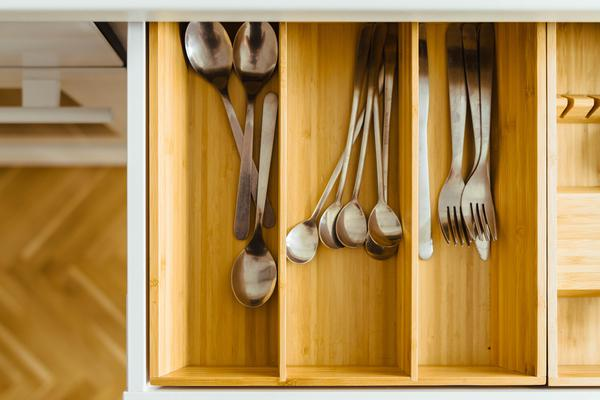

In [67]:
p = 412

display_picture(id_to_name[p])

display_results(search_image(5, id_to_embedding[p]))

In [68]:
search_image(5, id_to_embedding[p])

[[144.05258, 'e11a34d8-846a-45f0-967a-39d176b491bc', 'housewares'],
 [75.50531, '0121f086-4d27-4bbb-bd44-a90b34d86983', 'furniture'],
 [69.91753, 'c778bc2b-67c4-45d3-ba2d-3d91f7744f15', 'furniture'],
 [69.20247, '6d9480ff-36c6-4ece-a685-f7b55958b57b', 'furniture'],
 [68.973854, '36cfd856-dd30-46a9-8654-1f1de77e674a', 'floral']]